### 1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [72]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [73]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [74]:
def residual(y, z):
    return - (z - y)

In [75]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
# Число деревьев в ансамбле
n_trees = 10

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [10]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1114.3875412411571
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4454.413034376197


In [11]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

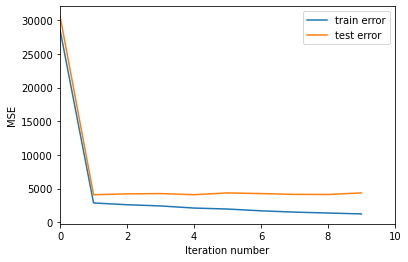

In [12]:
get_error_plot(n_trees, train_errors, test_errors)

График зависимости от количества деревьев и максимальной глубины

In [30]:
import seaborn as sns
import pandas as pd

In [76]:
max_trees = 50
max_depth = 10

trees = range(1, max_trees, 5)
depths = range(1, max_depth)
train_data = []
test_data = []

In [77]:
for tree in trees:
    for depth in depths:
        trees, train_errors, test_errors = gb_fit(tree, depth, X_train, X_test, y_train, y_test, eta)
        train_prediction = gb_predict(X_train, trees, eta)
        train_error = mean_squared_error(y_train, train_prediction)
        train_data.append((tree, depth, train_error))
        
        test_prediction = gb_predict(X_test, trees, eta)
        test_error = mean_squared_error(y_test, test_prediction)
        test_data.append((tree, depth, test_error))

KeyboardInterrupt: 

Остановил обучение, т.к. слишком долгое (>8 часов)

In [78]:
def plot(plot_data):
    data = pd.DataFrame({'n_tree': np.array(plot_data)[:, 0], 'depth':  np.array(plot_data)[:, 1], 'error':  np.array(plot_data)[:, 2]})
    data_pivoted = data.pivot("n_tree", "depth", "error")
    ax = sns.heatmap(data_pivoted)
    plt.show()

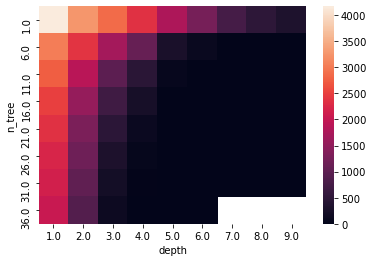

In [79]:
plot(train_data)

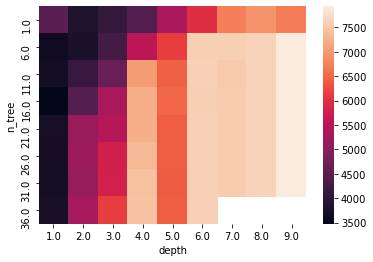

In [80]:
plot(test_data)

Из графиков видно как темная область насыщается при увеличении количества деревьев и глубины, и светлеет на тестововой выборке. Т.е. модель переобучается.

### 2. * Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

### 3. *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

In [192]:
# Вариант 1 - Исходный
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [193]:
%%time

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
train_errors, test_errors

CPU times: user 1.92 s, sys: 13.5 ms, total: 1.93 s
Wall time: 1.93 s


([28560.71601208459,
  198.25738648802493,
  27.003465215750857,
  4.7046569133295515,
  0.960293535879812,
  0.08712616220551544,
  0.011525230568124092,
  0.0018897769287504486,
  0.0003833526132316238,
  5.702459095689627e-05],
 [30606.522522522522,
  6703.638526595804,
  6899.045852060265,
  6901.817094677271,
  6895.0991023954275,
  6893.044310412608,
  6897.045917634184,
  6896.531472016213,
  6895.561184681848,
  6895.9372203327375])

In [212]:
# Вариант 2 - применение predict к вектору X + apply_along_axis для суммы предсказаний
def gb_predict(X, trees_list, eta):
    f = np.array([eta * t.predict(X) for t in trees_list])
    predictions = np.apply_along_axis(sum, 0, f)

    return predictions

In [213]:
%%time

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
train_errors, test_errors

CPU times: user 70.4 ms, sys: 2.62 ms, total: 73.1 ms
Wall time: 71.7 ms


([28560.71601208459,
  198.25738648802493,
  27.003465215750857,
  4.7046569133295515,
  0.960293535879812,
  0.08712616220551544,
  0.011525230568124092,
  0.0018897769287504486,
  0.0003833526132316238,
  5.702459095689627e-05],
 [30606.522522522522,
  6703.638526595804,
  6899.045852060265,
  6901.817094677271,
  6895.0991023954275,
  6893.044310412608,
  6897.045917634184,
  6896.531472016213,
  6895.561184681848,
  6895.9372203327375])

In [214]:
# Вариант 3 - lambda + map + apply_along_axis
def gb_predict(X, trees_list, eta):
    t_l = lambda t: eta * t.predict(X)
    f = np.array(list(map(t_l, trees_list)))
    predictions = np.apply_along_axis(sum, 0, f)

    return predictions

In [215]:
%%time

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
train_errors, test_errors

CPU times: user 68.9 ms, sys: 2.93 ms, total: 71.8 ms
Wall time: 70.7 ms


([28560.71601208459,
  198.25738648802493,
  27.003465215750857,
  4.7046569133295515,
  0.960293535879812,
  0.08712616220551544,
  0.011525230568124092,
  0.0018897769287504486,
  0.0003833526132316238,
  5.702459095689627e-05],
 [30606.522522522522,
  6703.638526595804,
  6899.045852060265,
  6901.817094677271,
  6895.0991023954275,
  6893.044310412608,
  6897.045917634184,
  6896.531472016213,
  6895.561184681848,
  6895.9372203327375])

In [218]:
# Вариант 4 - vectorized lambda + map
def gb_predict(X, trees_list, eta):
    t_l = lambda t: eta * t.predict(X)
    v_t_l = np.vectorize(t_l)
    f = np.array(list(map(v_t_l, trees_list)))
    predictions = np.apply_along_axis(sum, 0, f)

    return predictions

In [219]:
%%time

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
train_errors, test_errors

CPU times: user 79.4 ms, sys: 2.33 ms, total: 81.7 ms
Wall time: 81.4 ms


([28560.71601208459,
  198.25738648802493,
  27.003465215750857,
  4.7046569133295515,
  0.960293535879812,
  0.08712616220551544,
  0.011525230568124092,
  0.0018897769287504486,
  0.0003833526132316238,
  5.702459095689627e-05],
 [30606.522522522522,
  6703.638526595804,
  6899.045852060265,
  6901.817094677271,
  6895.0991023954275,
  6893.044310412608,
  6897.045917634184,
  6896.531472016213,
  6895.561184681848,
  6895.9372203327375])

Самый быстрый вариант из предложенных вариантов: Вариант 3 - lambda + map + apply_along_axis. lambda и map особой роли не играет. Основной прирост скорости в примении predict на векторе и использование apply_along_axis для суммы предсказаний по деревьем.

Предполагаю, что по аналогии с predict, как-то можно применить все действия к вектору trees_list разом.